# 1. Setup

In [1]:
import numpy as np
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = False

In [2]:
data_path = Path('./data')
model_path = Path('./models')

model_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Load data
ts1 = pickle.load(open(data_path / 'time_series_1.pickle', 'rb'))
ts2 = pickle.load(open(data_path / 'time_series_2.pickle', 'rb'))
y = pickle.load(open(data_path / 'y.pickle', 'rb'))

In [4]:
# Merge the 2 input time series. This gives us (4000, 5000, 2), which corresponds to
# (n_sequences, n_timesteps, n_features) which is what is needed to train sequence
# models
X = np.stack([ts1, ts2], axis=2)
X.shape

(4000, 5000, 2)

In [11]:
def scale_data(X, scaler=None):
    # If no scaler is provided, create a scaler, then fit it to the data
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(X.reshape(-1, X.shape[2]))

    # Reshape the data to 2D for scaling, then reshape it back to its original shape
    scaled_data = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
    
    return scaler, scaled_data

# 2. Exploratory data analysis

## 2.1. Visualise the sensor data for each state

In [83]:
def plot_sample_data(X, timesteps_to_plot=100):
    for turbine_mode in set(y):
        # Take the first 3 samples
        sample_turbine_mode_indices = np.argwhere(y == turbine_mode)[:3].squeeze()

        fig, axs = plt.subplots(3, 2, figsize=(15, 6))
        fig.suptitle(f'Sensor data for turbine mode {turbine_mode}')

        for row_num, sample_turbine_mode_index in enumerate(sample_turbine_mode_indices):
            for col_num in (0, 1):
                # Plot the beginning of the sequence to the left and the end to the right
                if col_num == 0:
                    plot_data = X[sample_turbine_mode_index][:timesteps_to_plot]
                else:
                    plot_data = X[sample_turbine_mode_index][timesteps_to_plot:]
                
                ax_to_plot = axs[row_num, col_num]

                ax_to_plot.plot(plot_data[:, 0].squeeze(), alpha=0.5)

                ax_to_plot.twinx()
                ax_to_plot.plot(plot_data[:, 1].squeeze(), alpha=0.5)

                ax_to_plot.get_xaxis().set_visible(False)

        plt.show()

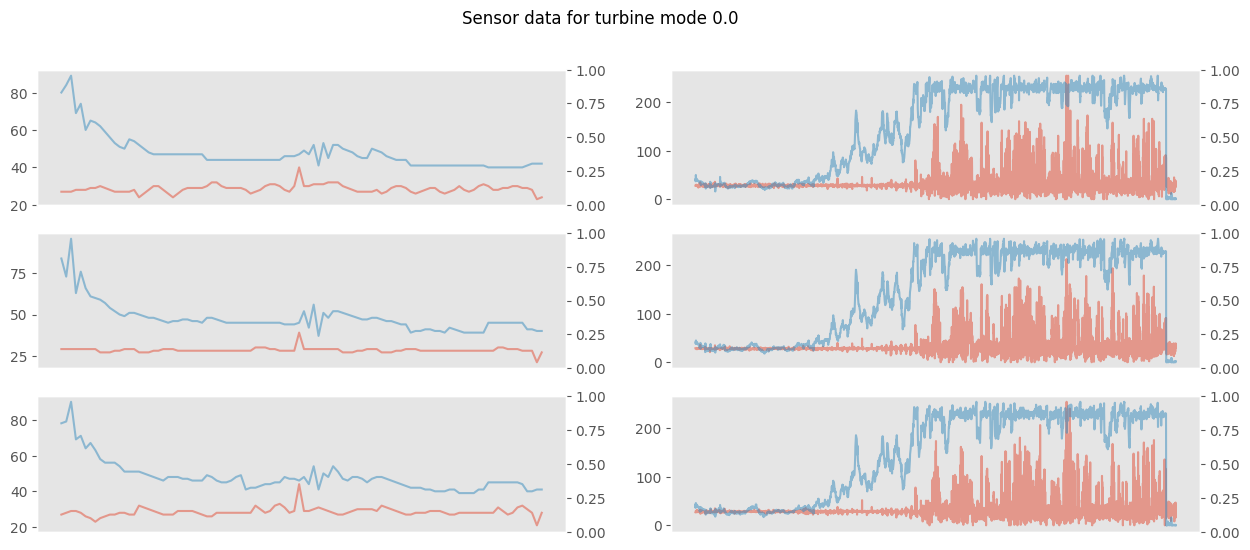

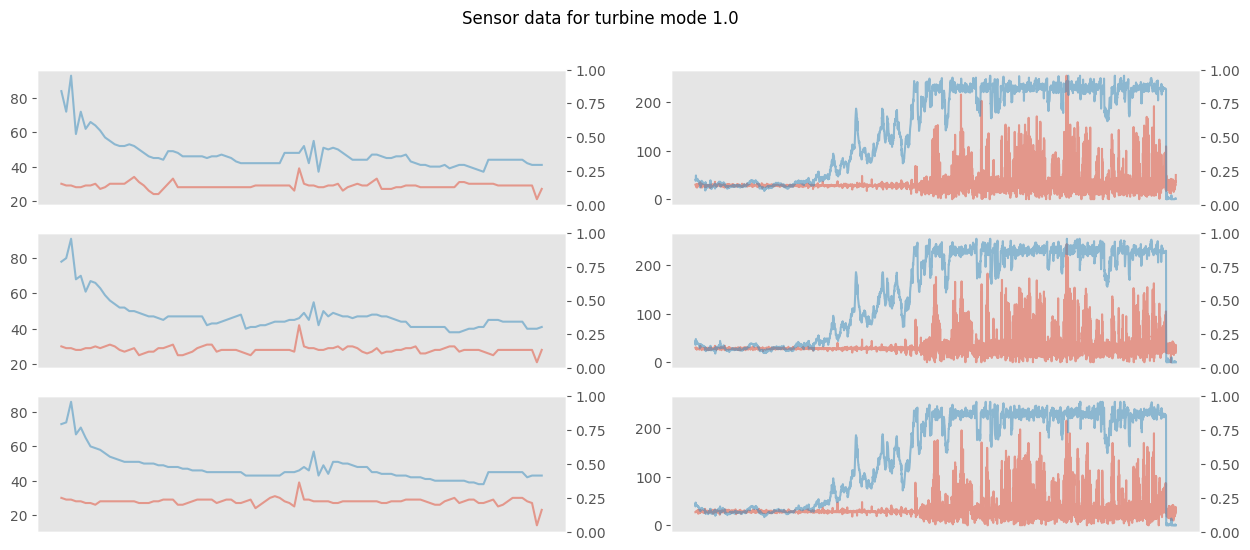

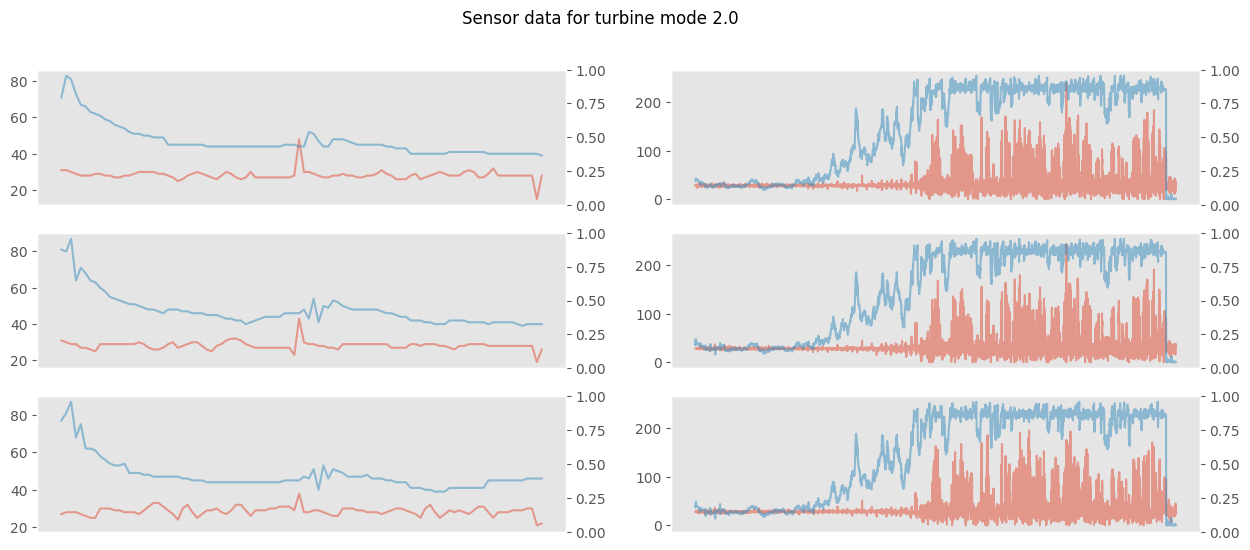

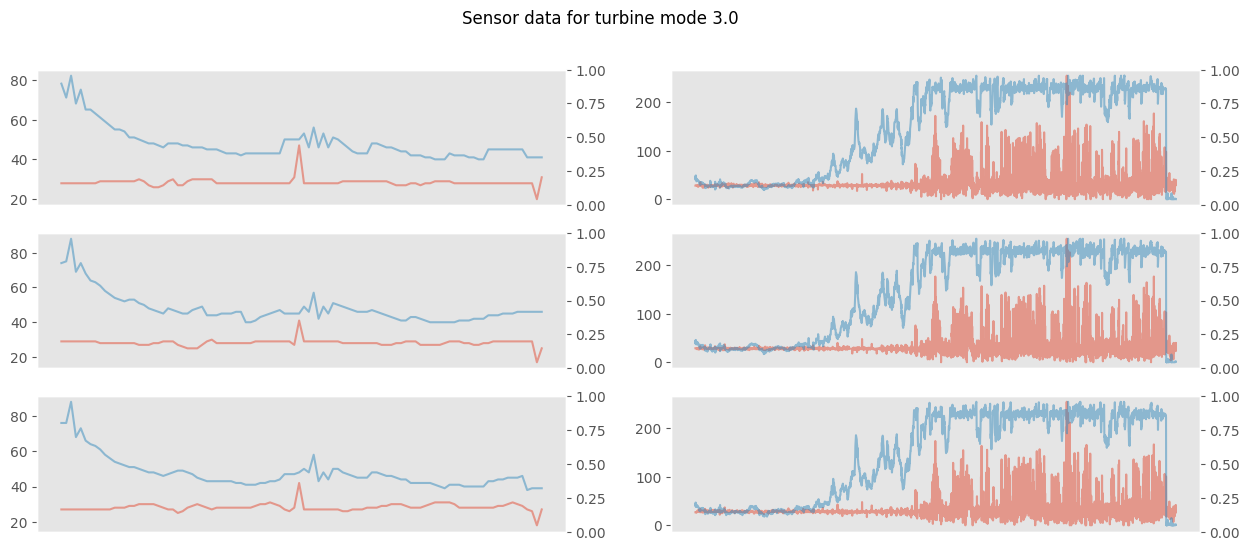

In [84]:
plot_sample_data(X)

There's no visual difference between the sensor data of the 4 modes.

In [90]:
def plot_average_sensor_data(X):
    fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    for i, turbine_mode in enumerate(set(y)):
        turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

        axs[i].set_title(f'Average sensor data for turbine mode {turbine_mode}')

        plot_data = X[turbine_mode_indices].mean(axis=0)

        axs[i].plot(plot_data[:, 0].squeeze(), alpha=.5)
        axs[i].twinx()
        axs[i].plot(plot_data[:, 1].squeeze(), alpha=.5)

    plt.show()


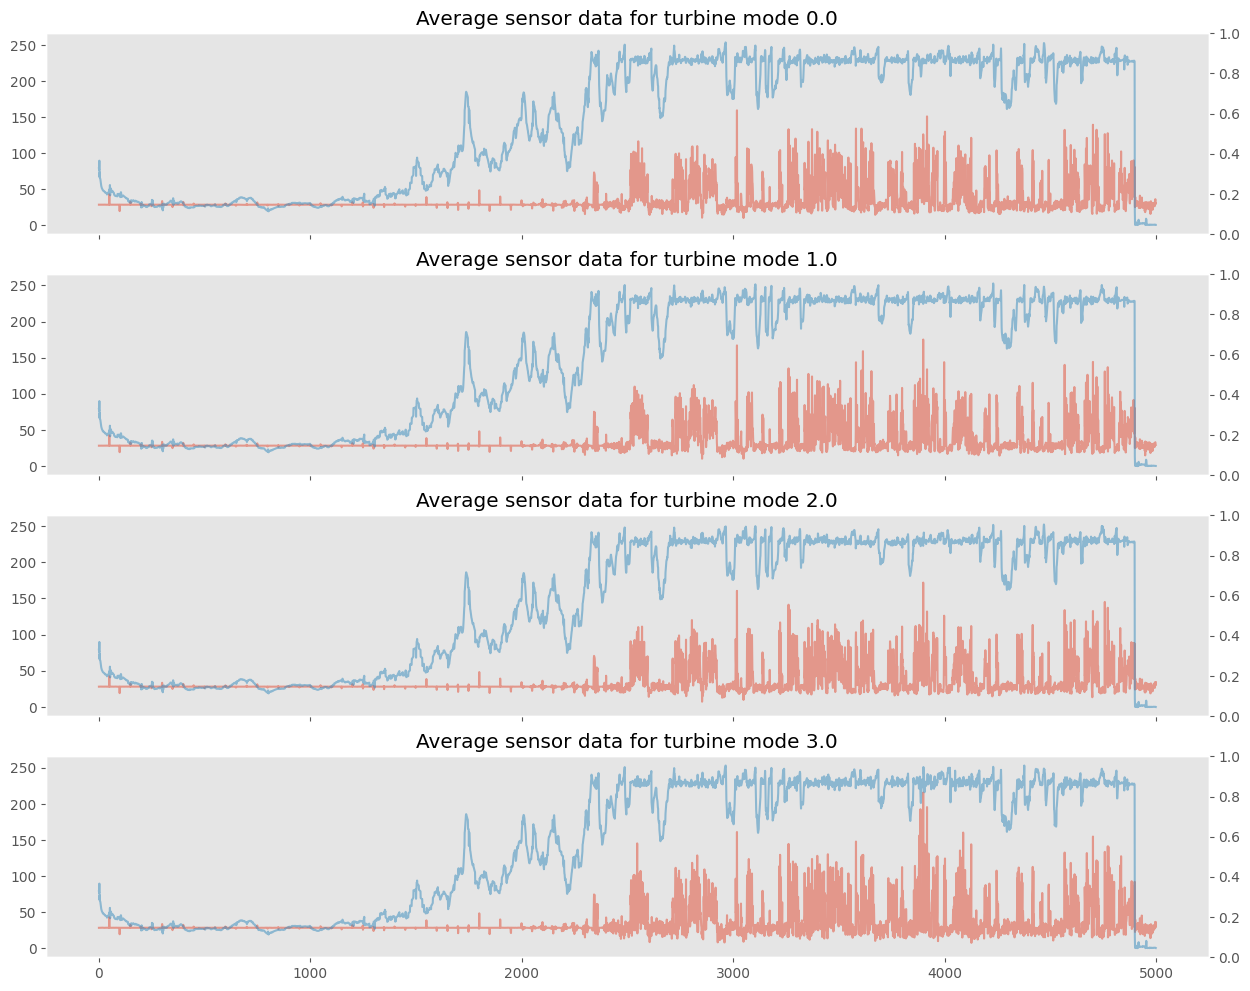

In [91]:
plot_average_sensor_data(X)

However, when we look at the average of each mode, there's something quite noticeable: Around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes. Therefore, the differences between the readings of the 2 sensors may be useful here.

## 2.2. Visualising scaled data

In [ ]:
print(stats.describe(np.vstack(X)))

DescribeResult(nobs=20000000, minmax=(array([0, 0], dtype=uint8), array([255, 255], dtype=uint8)), mean=array([ 34.72364305, 143.11656495]), variance=array([ 494.10723608, 7862.09026855]), skewness=array([ 2.99150686, -0.26584355]), kurtosis=array([11.89889674, -1.6850116 ]))


Overall, the reading of sensors appear to have the same lower and upper bounds, from 0 to 255. However, on average, the second sensor have much more variance and value than the first one. We can consider the second sensor to be on a different scale. Therefore, let's try to normalise them to 0 mean and unit variance for ease of analysis. However, when we get to the modelling stage, the scaling would only be fitted on the training set.

In [125]:
scaler, X_scaled = scale_data(X)

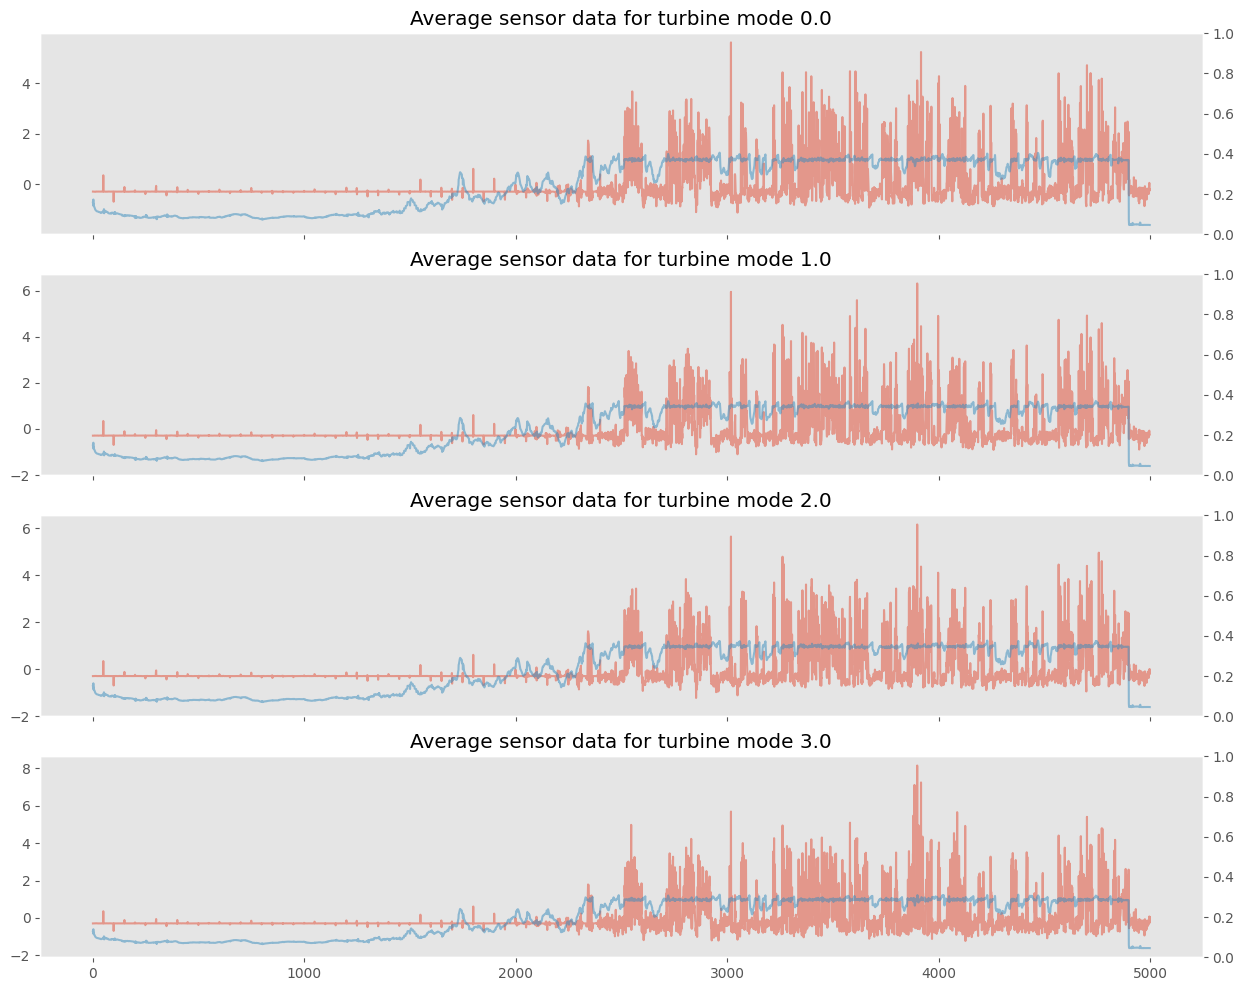

In [126]:
plot_average_sensor_data(X_scaled)

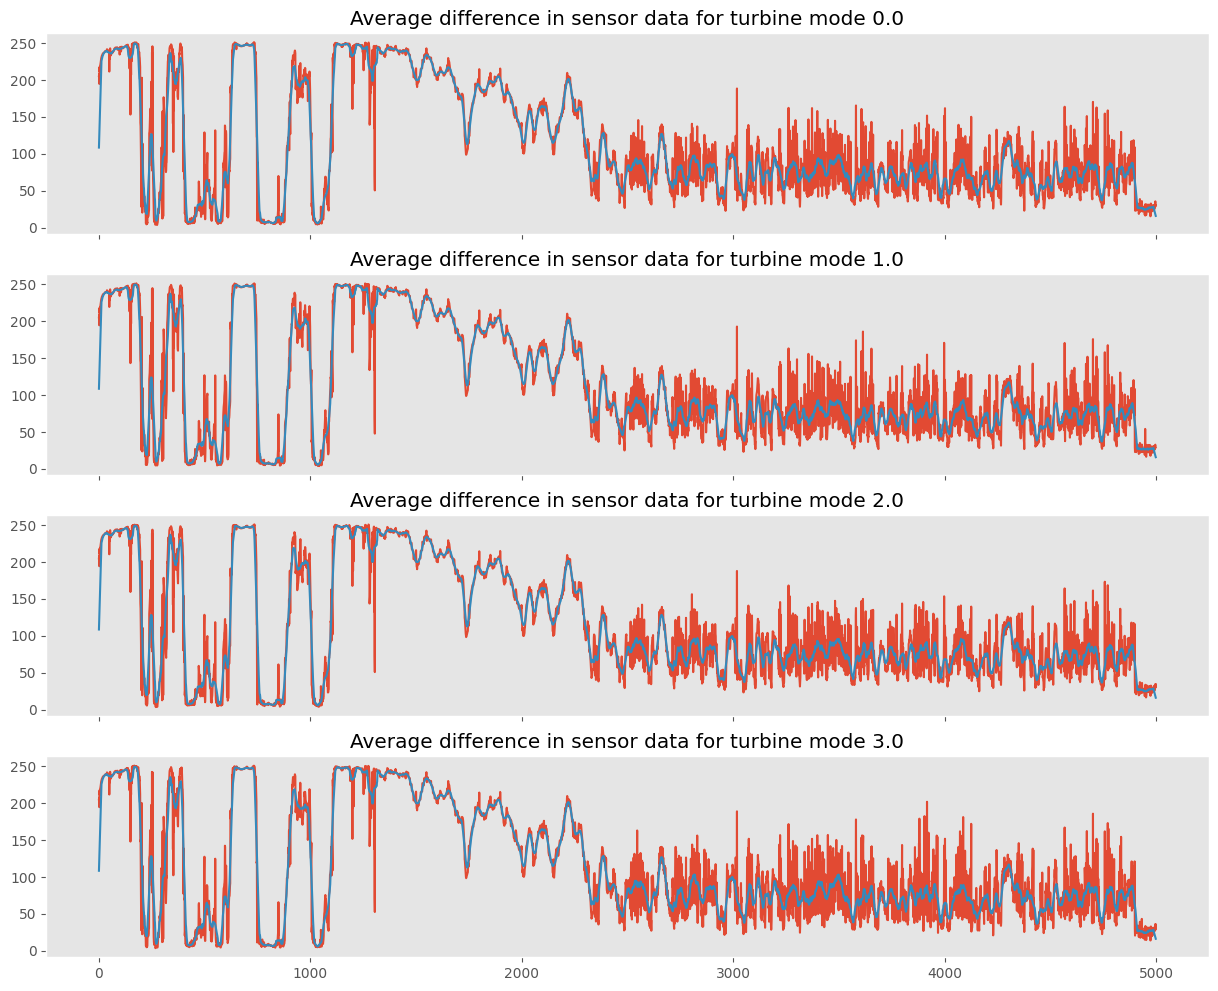

In [129]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

for i, turbine_mode in enumerate(set(y)):
    turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

    sensor_data = X[turbine_mode_indices, :, :]
    
    plot_data = (sensor_data[:, :, 0] - sensor_data[:, :, 1]).mean(axis=0)

    axs[i].set_title(f'Average difference in sensor data for turbine mode {turbine_mode}')
    axs[i].plot(plot_data.squeeze())
    axs[i].plot(np.convolve(plot_data.squeeze(), np.ones(24) / 24, mode='same'))

plt.show()


## 2.3. Summary statistics

In [130]:
for turbine_mode in set(y):
    turbine_mode_indices = np.argwhere(y == turbine_mode).flatten()

    sensor_data = X_scaled[turbine_mode_indices, :, :]

    # Add rate of change
    sensor_data = np.concatenate(
        [
            sensor_data,
            (sensor_data[:, :, 0] - sensor_data[:, :, 1])[..., np.newaxis],
        ],
        axis=2,
    )

    print(f'Summary statistic for turbine mode {turbine_mode}')
    print(stats.describe(np.vstack(sensor_data)))

Summary statistic for turbine mode 0.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.29065275])), mean=array([-1.36906311e-03, -3.12326507e-05, -1.33783045e-03]), variance=array([1.00356418, 0.99997435, 1.46111824]), skewness=array([ 3.02111839, -0.26575111,  0.34790822]), kurtosis=array([12.2643988 , -1.68523873,  1.39216469]))
Summary statistic for turbine mode 1.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.17787303])), mean=array([-0.00245772,  0.00163809, -0.00409581]), variance=array([1.00053517, 1.00297503, 1.4607519 ]), skewness=array([ 3.02892768, -0.26552219,  0.34254938]), kurtosis=array([12.21447021, -1.68566997,  1.28036494]))
Summary statistic for turbine mode 2.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.20042897])), mean=array([ 0.00044677, -0.0018547 

Very small differences in terms of summary statistics

Some hypotheses:
- The anomalies are very subtle and very hard to capture visually
- Local patterns

# 3. Modelling

**Question 1**: Discuss what type of sequence prediction approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible to predict the operating mode of a turbine based on the two sensor reading time series. Also describe what data shape you need to use for your chosen approach.

**Answer**:

- **sequence-to-vector**: This is a natural choice - We have 4000 sequences that matches to 4000 operating modes.
- **sequence-to-sequence**: When the output can be a sequence (e.g., time series), or when there is some dependency between the operating modes. However in our case, there is no time information so we won't be able to connect these 4000 operating modes. We can treat them as independent. Also, each sequence has a length of 5000, and we only have one label for the whole sequence, so won't be able to model this as a seq-to-seq problem. Also we don't even know if the sequences are ordered.
- **encoder-decoder**: Works best for translation tasks, or when output is not a scalar.

To follow the sequence-to-vector approach, the data shape needs to be processed as follows:
- input: `(batch_size, n_timesteps, n_features)`.
- Output: `(batch_size, )`. 

In our case, if the batch size is 64 and the sequences are passed in without further processing, the input shape would be `(64, 5000, 2)` and the output shape would be `(64, )`

**Question 2**: Create an iterator (ideally, a tensorflow.data.Dataset) that produces batches of data formatted in the appropriate way for your chosen approach.

In [6]:
# Train test split 80% of the data is used for training. This is consistent with the
# approach's in the "Convolutional Neural Network Fault Classification Based on
# Time-series Analysis for Benchmark Wind Turbine Machine" paper, which we are trying to
# implement

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, stratify=y_other, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3200, 5000, 2) (400, 5000, 2) (400, 5000, 2)


In [12]:
# Scale data
scaler, X_train_scaled = scale_data(X_train, scaler=None)
scaler, X_val_scaled = scale_data(X_val, scaler=scaler)
scaler, X_test_scaled = scale_data(X_test, scaler=scaler)

In [13]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
    .shuffle(10)
    .batch(64)
    .prefetch(1)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))
    .batch(64)
    .prefetch(1)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
    .batch(64)
    .prefetch(1)
)

In [14]:
def train_model(model, model_checkpoint):
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path / model_checkpoint, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    ]

    log = history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        callbacks=callbacks,
    )

    fig, axs = plt.subplots()
    axs.plot(history.history['accuracy'], label="training accuracy")
    axs.plot(history.history['val_accuracy'], label="validation accuracy")
    plt.legend()
    plt.show()

    _, train_accuracy = model.evaluate(train_dataset)
    _, val_accuracy = model.evaluate(val_dataset)
    _, test_accuracy = model.evaluate(test_dataset)

    return model, (train_accuracy, val_accuracy, test_accuracy)

## 3.1. Baseline

- Predict randomly -> We can get around 25% accuracy
- Build a multi-class logistic regression to predict the turbine mode based on the summary statistics
- Smoothen then downsample the sequences, flatten them and use a tree model to classify

## 3.2. Main approach

### 3.2.1. Basic neural network

**Question 3**: Create a neural network in TensorFlow to predict the operating mode of a wind turbine based on the sensor data. Make sure that you try out different layers and elements discussed in class, such as Dense, SimpleRNN, GRU, and Conv1D.

**Answer:**

As a first baseline, we create a simple neural network with a Conv1D layer as hidden layer. We do have the option of using a `GlobalAveragePooling1D` layer after the conv1D instead of a `Flatten` layer, but since we only have 64 filters of Conv1D of size 6, the number of parameters is still quite small, so averaging may result in too much information loss and is not totally necessary.

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Conv1D(64, 6, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4995, 64)          832       
                                                                 
 flatten (Flatten)           (None, 319680)            0         
                                                                 
 dense (Dense)               (None, 4)                 1278724   
                                                                 
Total params: 1,279,556
Trainable params: 1,279,556
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 6.3906 - accuracy: 0.6438

INFO:tensorflow:Assets written to: models\conv1d\assets


INFO:tensorflow:Assets written to: models\conv1d\assets


50/50 [==============================] - 29s 101ms/step - loss: 6.3906 - accuracy: 0.6438 - val_loss: 0.5067 - val_accuracy: 0.9050
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.8747

INFO:tensorflow:Assets written to: models\conv1d\assets


INFO:tensorflow:Assets written to: models\conv1d\assets


50/50 [==============================] - 3s 58ms/step - loss: 0.3166 - accuracy: 0.8750 - val_loss: 0.3264 - val_accuracy: 0.9025
Epoch 3/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2518 - accuracy: 0.8925 - val_loss: 0.3491 - val_accuracy: 0.9000
Epoch 4/100
49/50 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.8932

INFO:tensorflow:Assets written to: models\conv1d\assets


INFO:tensorflow:Assets written to: models\conv1d\assets


50/50 [==============================] - 3s 59ms/step - loss: 0.2319 - accuracy: 0.8931 - val_loss: 0.3068 - val_accuracy: 0.9025
Epoch 5/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2074 - accuracy: 0.9109 - val_loss: 0.3119 - val_accuracy: 0.9050
Epoch 6/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2125 - accuracy: 0.9034 - val_loss: 0.4110 - val_accuracy: 0.9025
Epoch 7/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2055 - accuracy: 0.9112 - val_loss: 0.4143 - val_accuracy: 0.9025
Epoch 8/100
49/50 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9072

INFO:tensorflow:Assets written to: models\conv1d\assets


INFO:tensorflow:Assets written to: models\conv1d\assets


50/50 [==============================] - 3s 58ms/step - loss: 0.2090 - accuracy: 0.9062 - val_loss: 0.2885 - val_accuracy: 0.8850
Epoch 9/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1740 - accuracy: 0.9147 - val_loss: 0.3308 - val_accuracy: 0.8500
Epoch 10/100
50/50 [==============================] - 2s 38ms/step - loss: 0.1300 - accuracy: 0.9416 - val_loss: 0.3170 - val_accuracy: 0.8750
Epoch 11/100
50/50 [==============================] - 2s 38ms/step - loss: 0.1232 - accuracy: 0.9416 - val_loss: 0.3684 - val_accuracy: 0.8550
Epoch 12/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1293 - accuracy: 0.9359 - val_loss: 0.3389 - val_accuracy: 0.9025
Epoch 13/100
50/50 [==============================] - 2s 43ms/step - loss: 0.0985 - accuracy: 0.9566 - val_loss: 0.3630 - val_accuracy: 0.9000
Epoch 14/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0829 - accuracy: 0.9663 - val_loss: 0.4273 - val_accuracy: 0.8975
Epoch 15/100


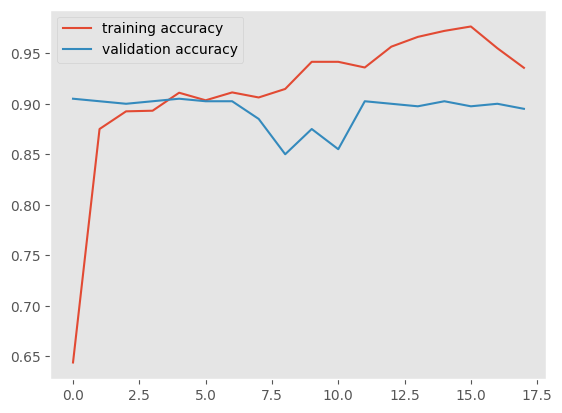

7/7 [==============================] - 0s 18ms/step - loss: 0.4368 - accuracy: 0.8725


In [15]:
model, accuracies = train_model(model, 'conv1d')

The model is clearly overfitting, with the training accuracy still increasing but validation accuracy has stopped improving after 8 peochs. This is understandable as this is a relatively simple model with no regularisation implemented. However, we have well surpassed the baseline of 25% accuracy.

**Question 4a:** We have come across Conv1D layers as a tool for analyzing time series. Different from recurrent layers such as SimpleRNN, LSTM, or GRU, when we apply a Conv1D layer to a part of a sequence, the operation does not depend on the application of the layer to previous parts of the sequence.

Discuss in which types of (business) applications Conv1D layers can be particularly useful, and in which you should prefer a recurrent layer. 

**Answer:** Convolutional layers in general are useful for problems where a sub-section of the data can be informative, regardless of its position. Therefore, Conv1D layers are useful in applications such as anomaly detection for time series, or time series classification (like this task) where each class can be determined by a local pattern, for example, sudden spikes in sensor readings can be attributed to faulty equipments. In contrast, recurrent layers are more suited for applications where the long-term, sequential dependency in data is important, for example, time series prediction, speech recognition. In our case, this could be relevant if the task is to predict the next `n` sensor readings, because the next sensor readings heavily depends on the previous readings.

In addition, since convolutional layers can be trained in parallel they are more suitable for applications involving a large volume of data, or long sequences, or with limited computing power than recurrent layers, which need to be trained sequentially.

### 3.2.2. Conv2D

**Question 5:** Another, less frequently used tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 which depict the process of converting one or multiple time series into “images” used within a CNN.

In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs


**Answer:** Based on the insights in section 2 - Exploratory data analysis, there is very little to no difference in the overall trends of 4 turbine modes. Therefore, sequential models such as RNNs might not perform well. In contrast, convolutional layers can work really well in our problem because local pattern may provide strong signals for identifying the turbine modes (e.g., in section 2, around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes.)

In the paper, the novelty is in the way the timeseries data are transformed into images - that is by dividing the time series (1 dimensional) into sequences of equal length and stack them vertically to construct a 2-dimensional array. This method may work really well for our problem, because there may be a cyclical pattern in the data. This is because the movement of the wind turbine blades are repetitive, which can produce cyclical data. Therefore, if the length of the sub-sequence are chosen carefully, the correlation between two adjacent elements in the 2D array could be very high for turbines operating in normal conditions.

For example, assuming we have a sensor that records the angle of a turbine blade in regular intervals, then the data it produces may be `120-240-360-120-240-360-120-240-360`. If the turbine functions normally, then we can expect the sub-sequence of `120-240-360` to repeat indefinitely. However, the angles of a mal-functioning turbine blade may be `120-242-360-120-241-360-120-239-360`. This difference is very subtle and would be impossible to notice visually. But if we follow the paper's approach by diving the data into sequences of length 3 and stacking them vertically, we will have the following:

- Healthy turbine:
```
| 120 | 240 | 360 |
| 120 | 240 | 360 |
| 120 | 240 | 360 |
```

- Mal-functioning turbine:
```
| 120 | 242 | 360 |
| 120 | 241 | 360 |
| 120 | 239 | 360 |
```

A 2D convolutional layer will be able to pick up the difference in the turbine blade's angles in the second column of the mal-functioning turbine's data.

**Question 6:** Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).

In [108]:
def reshape_x(X):
    image_dim = int(np.sqrt(X.shape[1] * X.shape[2]))
    reshaped = np.concatenate(
        [
            X[:, :, 0].reshape(X.shape[0], image_dim, -1),
            X[:, :, 1].reshape(X.shape[0], image_dim, -1),
        ],
        axis=2
    )

    return reshaped[..., np.newaxis]

Let's test our function on some dummy data

In [106]:
example_data = np.arange(1, 9)
example_sequence = np.array([
    example_data,
    example_data * 10,
]).T

example_sequences = np.array([example_sequence, example_sequence + .1, example_sequence + .2])
print(example_sequences.shape)
example_sequences

(3, 8, 2)


array([[[ 1. , 10. ],
        [ 2. , 20. ],
        [ 3. , 30. ],
        [ 4. , 40. ],
        [ 5. , 50. ],
        [ 6. , 60. ],
        [ 7. , 70. ],
        [ 8. , 80. ]],

       [[ 1.1, 10.1],
        [ 2.1, 20.1],
        [ 3.1, 30.1],
        [ 4.1, 40.1],
        [ 5.1, 50.1],
        [ 6.1, 60.1],
        [ 7.1, 70.1],
        [ 8.1, 80.1]],

       [[ 1.2, 10.2],
        [ 2.2, 20.2],
        [ 3.2, 30.2],
        [ 4.2, 40.2],
        [ 5.2, 50.2],
        [ 6.2, 60.2],
        [ 7.2, 70.2],
        [ 8.2, 80.2]]])

In [113]:
reshaped_exampled_sequences = reshape_x(example_sequences)
print(reshaped_exampled_sequences.shape)

reshaped_exampled_sequences[:, :, :, 0]

(3, 4, 4, 1)


array([[[ 1. ,  2. , 10. , 20. ],
        [ 3. ,  4. , 30. , 40. ],
        [ 5. ,  6. , 50. , 60. ],
        [ 7. ,  8. , 70. , 80. ]],

       [[ 1.1,  2.1, 10.1, 20.1],
        [ 3.1,  4.1, 30.1, 40.1],
        [ 5.1,  6.1, 50.1, 60.1],
        [ 7.1,  8.1, 70.1, 80.1]],

       [[ 1.2,  2.2, 10.2, 20.2],
        [ 3.2,  4.2, 30.2, 40.2],
        [ 5.2,  6.2, 50.2, 60.2],
        [ 7.2,  8.2, 70.2, 80.2]]])